In [10]:
pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


Below I set up the foundation for training a convolutional neural network on the CIFAR-10 dataset using PyTorch and torchvision. The dataset comprises 60,000 color images of 32×32 resolution, categorized into 10 distinct classes.  
The first step is defining the computation device, dynamically selecting cuda if a GPU is available; otherwise, defaulting to CPU. This ensures optimal performance by leveraging hardware acceleration when possible.  
A data transformation pipeline is then applied using transforms.Compose(), structuring a sequence of preprocessing steps. The images are resized to 32×32 pixels, preserving their original dimensions while enforcing uniformity. Conversion to PyTorch tensors follows, ensuring compatibility with the deep learning framework. Normalization is subsequently performed, scaling pixel intensities to a range of -1 to 1 with a mean of 0.5 and a standard deviation of 0.5 across the RGB channels. This normalization facilitates more stable and efficient training by mitigating variations in input distribution.  
Then, I loaded the CIFAR-10 dataset. The training set is instantiated with automatic downloading enabled to ensure availability. A DataLoader is constructed with a batch size of 128, shuffling the data to introduce stochasticity in the learning process. For the test set, an analogous procedure is followed, though shuffling is disabled to maintain a consistent order for evaluation, preserving reproducibility in performance assessment.  
Finally, the class labels are explicitly defined, mapping integer indices to semantic categories: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. These labels provide interpretability when analyzing the model’s predictions.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformation
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Below two snippets defined two convolutional neural network architectures: BaselineCNN, a custom-built model, and ResNet18, a pre-trained deep residual network adapted for CIFAR-10 classification.
The BaselineCNN class extends nn.Module and implements a three-layer convolutional network followed by fully connected layers. In the __init__ method, three 2D convolutional layers progressively increase feature map depth from 3 to 256 while preserving spatial structure with 3×3 filters and padding=1. Each convolutional layer is followed by a ReLU activation function and max pooling (MaxPool2d) with a 2×2 kernel and stride of 2, reducing spatial dimensions at each stage. After convolution, the feature maps are flattened into a one-dimensional vector using view(). The fully connected layer (fc1) with 512 neurons applies another ReLU activation, followed by a second linear layer (fc2) that maps features to 10 output classes, corresponding to CIFAR-10 categories. The forward() method processes input data sequentially through the convolutional layers, applying activation and pooling at each stage before flattening and passing through the fully connected layers. The final output consists of raw scores for each of the ten classes.
The ResNet18 class leverages a pre-trained ResNet-18 model, a deep residual network with skip connections designed to mitigate vanishing gradient issues. The __init__ method loads the pre-trained ResNet-18 model from torchvision.models, enabling transfer learning. The fully connected (fc) layer is modified to output 10 classes, replacing the original classification layer. The forward() method simply passes the input through the modified ResNet-18 model, utilizing its pre-trained convolutional filters for feature extraction. By fine-tuning only the final layer, this approach accelerates training and improves generalization by leveraging representations learned on large-scale datasets.

In [15]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)  # Modify output for 10 classes

    def forward(self, x):
        return self.model(x)

Please ignore this efficientnetb0 model for now, it run too slow so I decided to run it on another file and merge it later.

In [17]:
# class EfficientNetB0(nn.Module):
#     def __init__(self):
#         super(EfficientNetB0, self).__init__()
#         self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
#         self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 10)  # Modify output for 10 classes

#     def forward(self, x):
#         return self.model(x)



Th `train_modl` function trains a neural network using a specified optimizer and loss function while evaluating its performance on a test setAnd t The model is first moved to the appropriate device (GPU or CPU) for efficient execution. 

In the training phase, the model is set to training mode usng `model.tran(I used a` A `running_oss` variable tracks the total loss over batches. For each batch, images and labels are loaded onto the device, and a forward pass computes predictions. The loss is calculated and backpropagated, and before updating weights, previous gradients are cleared usng `optimizer.zero_grd()`. The model parameters are updated wth `optimizer.stp()`. Once all batches are processed, the average training loss is computed by dividing the total accumulated loss by the number of batche.  

In the evaluation phase, the model switches to evaluation modewith `model.val()`, ensuring deterministic behavior. Gradient calculations are disabled sing `torch.no_rad()` to save memory and speed up inference. The test dataset is processed in batches, where predictions are computed, and test loss is accumulated. Top-1 and top-5 accuracy are calculated. Top-1 accuracy checks if the highest-confidence prediction matches the true label, while top-5 accuracy considers a prediction correct if the true label appears in the five most confident out
puts. The average test loss and classification errors are recorded at the end of each epch.  

Once training is complete, the function prints the epoch number, average training loss, average test loss, and classification errors. The recorded losses and errors are then returned for further analysis and visualiztion.  


In [8]:
def train_model(model, optimizer, criterion, num_epochs=100):
    model.to(device)  # Move model to GPU or CPU
    train_losses, test_losses = [], []
    top1_errors, top5_errors = [], []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0  # Track training loss for the epoch

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)  # Move data to device

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            running_loss += loss.item()  # Accumulate batch loss

        # Compute average training loss for the epoch
        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # Evaluate on test set
        model.eval()  # Set model to evaluation mode
        correct_top1, correct_top5 = 0, 0  # Track top-1 and top-5 accuracy
        total = 0
        test_loss = 0.0  # Track test loss

        with torch.no_grad():  # Disable gradient computation for efficiency
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # Compute top-1 and top-5 accuracy
                _, preds = torch.topk(outputs, 5, dim=1)  # Get top-5 predictions
                correct_top1 += (preds[:, 0] == labels).sum().item()  # Top-1 matches
                correct_top5 += (preds == labels.view(-1, 1)).sum().item()  # Top-5 matches
                total += labels.size(0)

        # Compute average test loss for the epoch
        avg_test_loss = test_loss / len(testloader)
        test_losses.append(avg_test_loss)

        # Compute top-1 and top-5 error rates
        top1_error = 1 - (correct_top1 / total)
        top5_error = 1 - (correct_top5 / total)
        top1_errors.append(top1_error)
        top5_errors.append(top5_error)

        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}, Top-1 Error: {top1_error:.4f}, '
              f'Top-5 Error: {top5_error:.4f}')

    return train_losses, test_losses, top1_errors, top5_errors


Here I did not run the model 'EfficientNetB0' successfully, but I would run it in another file. I Saved the output for the first two models into separate csv files and try compare them below.

In [ ]:
# Hyperparameters
num_epochs = 50
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

# Train Baseline CNN
baseline_model = BaselineCNN()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=learning_rate)
baseline_results = train_model(baseline_model, optimizer_baseline, criterion, num_epochs)

# Train ResNet-18
resnet_model = ResNet18()
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=learning_rate)
resnet_results = train_model(resnet_model, optimizer_resnet, criterion, num_epochs)

# # Train EfficientNet-B0
# efficientnet_model = EfficientNetB0()
# optimizer_effnet = optim.Adam(efficientnet_model.parameters(), lr=learning_rate)
# effnet_results = train_model(efficientnet_model, optimizer_effnet, criterion, num_epochs)


Below is the output of model training while the first 50 epoches belonging to Baseline CNN and the second 50 epoches belong to ResNet-18.

Epoch [1/50], Train Loss: 1.3584, Test Loss: 1.0360, Top-1 Error: 0.3744, Top-5 Error: 0.0317
Epoch [2/50], Train Loss: 0.8970, Test Loss: 0.8347, Top-1 Error: 0.2954, Top-5 Error: 0.0226
Epoch [3/50], Train Loss: 0.6836, Test Loss: 0.7716, Top-1 Error: 0.2639, Top-5 Error: 0.0181
Epoch [4/50], Train Loss: 0.5408, Test Loss: 0.7165, Top-1 Error: 0.2448, Top-5 Error: 0.0152
Epoch [5/50], Train Loss: 0.4034, Test Loss: 0.7219, Top-1 Error: 0.2318, Top-5 Error: 0.0158
Epoch [6/50], Train Loss: 0.2849, Test Loss: 0.7952, Top-1 Error: 0.2416, Top-5 Error: 0.0187
Epoch [7/50], Train Loss: 0.1808, Test Loss: 0.8736, Top-1 Error: 0.2307, Top-5 Error: 0.0171
Epoch [8/50], Train Loss: 0.1211, Test Loss: 1.0369, Top-1 Error: 0.2327, Top-5 Error: 0.0147
Epoch [9/50], Train Loss: 0.0911, Test Loss: 1.0899, Top-1 Error: 0.2359, Top-5 Error: 0.0162
Epoch [10/50], Train Loss: 0.0780, Test Loss: 1.1897, Top-1 Error: 0.2316, Top-5 Error: 0.0173
Epoch [11/50], Train Loss: 0.0703, Test Loss: 1.2109, Top-1 Error: 0.2426, Top-5 Error: 0.0219
Epoch [12/50], Train Loss: 0.0621, Test Loss: 1.2300, Top-1 Error: 0.2282, Top-5 Error: 0.0197
Epoch [13/50], Train Loss: 0.0579, Test Loss: 1.3966, Top-1 Error: 0.2289, Top-5 Error: 0.0181
Epoch [14/50], Train Loss: 0.0494, Test Loss: 1.5156, Top-1 Error: 0.2423, Top-5 Error: 0.0189
Epoch [15/50], Train Loss: 0.0609, Test Loss: 1.4078, Top-1 Error: 0.2366, Top-5 Error: 0.0189
Epoch [16/50], Train Loss: 0.0429, Test Loss: 1.4416, Top-1 Error: 0.2339, Top-5 Error: 0.0197
Epoch [17/50], Train Loss: 0.0442, Test Loss: 1.5361, Top-1 Error: 0.2370, Top-5 Error: 0.0186
Epoch [18/50], Train Loss: 0.0566, Test Loss: 1.5863, Top-1 Error: 0.2417, Top-5 Error: 0.0206
Epoch [19/50], Train Loss: 0.0505, Test Loss: 1.6225, Top-1 Error: 0.2359, Top-5 Error: 0.0202
Epoch [20/50], Train Loss: 0.0375, Test Loss: 1.7485, Top-1 Error: 0.2449, Top-5 Error: 0.0211
Epoch [21/50], Train Loss: 0.0346, Test Loss: 1.7283, Top-1 Error: 0.2379, Top-5 Error: 0.0194
Epoch [22/50], Train Loss: 0.0408, Test Loss: 1.7260, Top-1 Error: 0.2410, Top-5 Error: 0.0238
Epoch [23/50], Train Loss: 0.0403, Test Loss: 1.7143, Top-1 Error: 0.2429, Top-5 Error: 0.0220
Epoch [24/50], Train Loss: 0.0459, Test Loss: 1.7864, Top-1 Error: 0.2429, Top-5 Error: 0.0213
Epoch [25/50], Train Loss: 0.0393, Test Loss: 1.9050, Top-1 Error: 0.2440, Top-5 Error: 0.0204
Epoch [26/50], Train Loss: 0.0303, Test Loss: 1.8531, Top-1 Error: 0.2359, Top-5 Error: 0.0206
Epoch [27/50], Train Loss: 0.0383, Test Loss: 1.9231, Top-1 Error: 0.2372, Top-5 Error: 0.0203
Epoch [28/50], Train Loss: 0.0358, Test Loss: 1.9606, Top-1 Error: 0.2435, Top-5 Error: 0.0215
Epoch [29/50], Train Loss: 0.0460, Test Loss: 1.8767, Top-1 Error: 0.2361, Top-5 Error: 0.0193
Epoch [30/50], Train Loss: 0.0312, Test Loss: 1.9848, Top-1 Error: 0.2389, Top-5 Error: 0.0178
Epoch [31/50], Train Loss: 0.0321, Test Loss: 1.9808, Top-1 Error: 0.2407, Top-5 Error: 0.0212
Epoch [32/50], Train Loss: 0.0339, Test Loss: 2.1362, Top-1 Error: 0.2398, Top-5 Error: 0.0204
Epoch [33/50], Train Loss: 0.0333, Test Loss: 2.1277, Top-1 Error: 0.2535, Top-5 Error: 0.0239
Epoch [34/50], Train Loss: 0.0335, Test Loss: 1.9953, Top-1 Error: 0.2407, Top-5 Error: 0.0225
Epoch [35/50], Train Loss: 0.0297, Test Loss: 2.0985, Top-1 Error: 0.2363, Top-5 Error: 0.0200
Epoch [36/50], Train Loss: 0.0364, Test Loss: 2.1234, Top-1 Error: 0.2491, Top-5 Error: 0.0214
Epoch [37/50], Train Loss: 0.0376, Test Loss: 2.1514, Top-1 Error: 0.2374, Top-5 Error: 0.0221
Epoch [38/50], Train Loss: 0.0328, Test Loss: 2.0700, Top-1 Error: 0.2358, Top-5 Error: 0.0190
Epoch [39/50], Train Loss: 0.0273, Test Loss: 2.2921, Top-1 Error: 0.2394, Top-5 Error: 0.0194
Epoch [40/50], Train Loss: 0.0297, Test Loss: 2.2405, Top-1 Error: 0.2430, Top-5 Error: 0.0207
Epoch [41/50], Train Loss: 0.0339, Test Loss: 2.3382, Top-1 Error: 0.2471, Top-5 Error: 0.0231
Epoch [42/50], Train Loss: 0.0312, Test Loss: 2.4064, Top-1 Error: 0.2454, Top-5 Error: 0.0201
Epoch [43/50], Train Loss: 0.0251, Test Loss: 2.4267, Top-1 Error: 0.2422, Top-5 Error: 0.0217
Epoch [44/50], Train Loss: 0.0227, Test Loss: 2.4771, Top-1 Error: 0.2460, Top-5 Error: 0.0220
Epoch [45/50], Train Loss: 0.0358, Test Loss: 2.2872, Top-1 Error: 0.2451, Top-5 Error: 0.0229
Epoch [46/50], Train Loss: 0.0303, Test Loss: 2.2891, Top-1 Error: 0.2376, Top-5 Error: 0.0240
Epoch [47/50], Train Loss: 0.0234, Test Loss: 2.3971, Top-1 Error: 0.2426, Top-5 Error: 0.0219
Epoch [48/50], Train Loss: 0.0326, Test Loss: 2.3155, Top-1 Error: 0.2386, Top-5 Error: 0.0223
Epoch [49/50], Train Loss: 0.0276, Test Loss: 2.3884, Top-1 Error: 0.2392, Top-5 Error: 0.0226
Epoch [50/50], Train Loss: 0.0277, Test Loss: 2.4345, Top-1 Error: 0.2357, Top-5 Error: 0.0224
/Users/lf/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lf/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/lf/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 31.3MB/s]
Epoch [1/50], Train Loss: 0.8826, Test Loss: 0.8471, Top-1 Error: 0.2860, Top-5 Error: 0.0256
Epoch [2/50], Train Loss: 0.5725, Test Loss: 0.6608, Top-1 Error: 0.2134, Top-5 Error: 0.0139
Epoch [3/50], Train Loss: 0.4390, Test Loss: 0.5912, Top-1 Error: 0.1952, Top-5 Error: 0.0107
Epoch [4/50], Train Loss: 0.3500, Test Loss: 0.6186, Top-1 Error: 0.1921, Top-5 Error: 0.0115
Epoch [5/50], Train Loss: 0.2745, Test Loss: 0.6301, Top-1 Error: 0.1921, Top-5 Error: 0.0112
Epoch [6/50], Train Loss: 0.2179, Test Loss: 0.6534, Top-1 Error: 0.1903, Top-5 Error: 0.0115
Epoch [7/50], Train Loss: 0.1648, Test Loss: 0.6765, Top-1 Error: 0.1840, Top-5 Error: 0.0121
Epoch [8/50], Train Loss: 0.1446, Test Loss: 0.7209, Top-1 Error: 0.1935, Top-5 Error: 0.0127
Epoch [9/50], Train Loss: 0.1180, Test Loss: 0.7219, Top-1 Error: 0.1888, Top-5 Error: 0.0130
Epoch [10/50], Train Loss: 0.1099, Test Loss: 0.7585, Top-1 Error: 0.1932, Top-5 Error: 0.0135
Epoch [11/50], Train Loss: 0.0941, Test Loss: 0.8002, Top-1 Error: 0.1896, Top-5 Error: 0.0128
Epoch [12/50], Train Loss: 0.0829, Test Loss: 0.8701, Top-1 Error: 0.1921, Top-5 Error: 0.0144
Epoch [13/50], Train Loss: 0.0872, Test Loss: 0.7749, Top-1 Error: 0.1826, Top-5 Error: 0.0138
Epoch [14/50], Train Loss: 0.0696, Test Loss: 0.7887, Top-1 Error: 0.1846, Top-5 Error: 0.0135
Epoch [15/50], Train Loss: 0.0558, Test Loss: 0.9085, Top-1 Error: 0.1977, Top-5 Error: 0.0152
Epoch [16/50], Train Loss: 0.0610, Test Loss: 0.8454, Top-1 Error: 0.1944, Top-5 Error: 0.0151
Epoch [17/50], Train Loss: 0.0642, Test Loss: 0.7786, Top-1 Error: 0.1798, Top-5 Error: 0.0134
Epoch [18/50], Train Loss: 0.0528, Test Loss: 0.8566, Top-1 Error: 0.1901, Top-5 Error: 0.0131
Epoch [19/50], Train Loss: 0.1060, Test Loss: 0.7483, Top-1 Error: 0.1909, Top-5 Error: 0.0140
Epoch [20/50], Train Loss: 0.0570, Test Loss: 0.9182, Top-1 Error: 0.1846, Top-5 Error: 0.0149
Epoch [21/50], Train Loss: 0.0367, Test Loss: 0.8841, Top-1 Error: 0.1797, Top-5 Error: 0.0131
Epoch [22/50], Train Loss: 0.0339, Test Loss: 0.9051, Top-1 Error: 0.1859, Top-5 Error: 0.0134
Epoch [23/50], Train Loss: 0.0374, Test Loss: 0.9252, Top-1 Error: 0.1836, Top-5 Error: 0.0141
Epoch [24/50], Train Loss: 0.0438, Test Loss: 0.8900, Top-1 Error: 0.1906, Top-5 Error: 0.0128
Epoch [25/50], Train Loss: 0.0342, Test Loss: 0.9676, Top-1 Error: 0.1845, Top-5 Error: 0.0164
Epoch [26/50], Train Loss: 0.0393, Test Loss: 0.9110, Top-1 Error: 0.1902, Top-5 Error: 0.0133
Epoch [27/50], Train Loss: 0.0316, Test Loss: 0.9840, Top-1 Error: 0.1911, Top-5 Error: 0.0146
Epoch [28/50], Train Loss: 0.0342, Test Loss: 0.9309, Top-1 Error: 0.1886, Top-5 Error: 0.0151
Epoch [29/50], Train Loss: 0.0408, Test Loss: 0.9325, Top-1 Error: 0.1880, Top-5 Error: 0.0126
Epoch [30/50], Train Loss: 0.0347, Test Loss: 0.9652, Top-1 Error: 0.1885, Top-5 Error: 0.0150
Epoch [31/50], Train Loss: 0.0305, Test Loss: 0.9599, Top-1 Error: 0.1891, Top-5 Error: 0.0159
Epoch [32/50], Train Loss: 0.0320, Test Loss: 0.9631, Top-1 Error: 0.1863, Top-5 Error: 0.0153
Epoch [33/50], Train Loss: 0.0293, Test Loss: 0.9724, Top-1 Error: 0.1862, Top-5 Error: 0.0148
Epoch [34/50], Train Loss: 0.0293, Test Loss: 1.0700, Top-1 Error: 0.1979, Top-5 Error: 0.0161
Epoch [35/50], Train Loss: 0.0938, Test Loss: 0.9195, Top-1 Error: 0.1813, Top-5 Error: 0.0151
Epoch [36/50], Train Loss: 0.0144, Test Loss: 1.0548, Top-1 Error: 0.1810, Top-5 Error: 0.0149
Epoch [37/50], Train Loss: 0.0155, Test Loss: 1.0388, Top-1 Error: 0.1884, Top-5 Error: 0.0160
Epoch [38/50], Train Loss: 0.0210, Test Loss: 1.0894, Top-1 Error: 0.1932, Top-5 Error: 0.0162
Epoch [39/50], Train Loss: 0.0240, Test Loss: 0.9740, Top-1 Error: 0.1836, Top-5 Error: 0.0155
Epoch [40/50], Train Loss: 0.0216, Test Loss: 1.0276, Top-1 Error: 0.1872, Top-5 Error: 0.0166
Epoch [41/50], Train Loss: 0.0235, Test Loss: 1.0509, Top-1 Error: 0.1894, Top-5 Error: 0.0147
Epoch [42/50], Train Loss: 0.0255, Test Loss: 1.0083, Top-1 Error: 0.1879, Top-5 Error: 0.0138
Epoch [43/50], Train Loss: 0.0187, Test Loss: 1.0788, Top-1 Error: 0.1873, Top-5 Error: 0.0150
Epoch [44/50], Train Loss: 0.0254, Test Loss: 1.1158, Top-1 Error: 0.2000, Top-5 Error: 0.0148
Epoch [45/50], Train Loss: 0.0280, Test Loss: 1.0328, Top-1 Error: 0.1886, Top-5 Error: 0.0145
Epoch [46/50], Train Loss: 0.0196, Test Loss: 0.9842, Top-1 Error: 0.1769, Top-5 Error: 0.0118
Epoch [47/50], Train Loss: 0.0102, Test Loss: 1.1535, Top-1 Error: 0.1856, Top-5 Error: 0.0153
Epoch [48/50], Train Loss: 0.0252, Test Loss: 1.0746, Top-1 Error: 0.1882, Top-5 Error: 0.0151
Epoch [49/50], Train Loss: 0.0249, Test Loss: 1.0766, Top-1 Error: 0.1890, Top-5 Error: 0.0155
Epoch [50/50], Train Loss: 0.0192, Test Loss: 1.1082, Top-1 Error: 0.1821, Top-5 Error: 0.0148
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
/var/folders/p4/jkbjhq_n5sj4zf4ps15p54z40000gn/T/ipykernel_1630/2916849933.py in <module>
     16 
     17 # Train EfficientNet-B0
---> 18 efficientnet_model = EfficientNetB0()
     19 optimizer_effnet = optim.Adam(efficientnet_model.parameters(), lr=learning_rate)
     20 effnet_results = train_model(efficientnet_model, optimizer_effnet, criterion, num_epochs)

NameError: name 'EfficientNetB0' is not defined


In [20]:
import re
import pandas as pd
import matplotlib.pyplot as plt

#  Sample log data for two models (Baseline CNN and ResNet-18)
log_baseline = """Epoch [1/50], Train Loss: 1.3584, Test Loss: 1.0360, Top-1 Error: 0.3744, Top-5 Error: 0.0317 Epoch [2/50], Train Loss: 0.8970, Test Loss: 0.8347, Top-1 Error: 0.2954, Top-5 Error: 0.0226 Epoch [3/50], Train Loss: 0.6836, Test Loss: 0.7716, Top-1 Error: 0.2639, Top-5 Error: 0.0181 Epoch [4/50], Train Loss: 0.5408, Test Loss: 0.7165, Top-1 Error: 0.2448, Top-5 Error: 0.0152 Epoch [5/50], Train Loss: 0.4034, Test Loss: 0.7219, Top-1 Error: 0.2318, Top-5 Error: 0.0158 Epoch [6/50], Train Loss: 0.2849, Test Loss: 0.7952, Top-1 Error: 0.2416, Top-5 Error: 0.0187 Epoch [7/50], Train Loss: 0.1808, Test Loss: 0.8736, Top-1 Error: 0.2307, Top-5 Error: 0.0171 Epoch [8/50], Train Loss: 0.1211, Test Loss: 1.0369, Top-1 Error: 0.2327, Top-5 Error: 0.0147 Epoch [9/50], Train Loss: 0.0911, Test Loss: 1.0899, Top-1 Error: 0.2359, Top-5 Error: 0.0162 Epoch [10/50], Train Loss: 0.0780, Test Loss: 1.1897, Top-1 Error: 0.2316, Top-5 Error: 0.0173 Epoch [11/50], Train Loss: 0.0703, Test Loss: 1.2109, Top-1 Error: 0.2426, Top-5 Error: 0.0219 Epoch [12/50], Train Loss: 0.0621, Test Loss: 1.2300, Top-1 Error: 0.2282, Top-5 Error: 0.0197 Epoch [13/50], Train Loss: 0.0579, Test Loss: 1.3966, Top-1 Error: 0.2289, Top-5 Error: 0.0181 Epoch [14/50], Train Loss: 0.0494, Test Loss: 1.5156, Top-1 Error: 0.2423, Top-5 Error: 0.0189 Epoch [15/50], Train Loss: 0.0609, Test Loss: 1.4078, Top-1 Error: 0.2366, Top-5 Error: 0.0189 Epoch [16/50], Train Loss: 0.0429, Test Loss: 1.4416, Top-1 Error: 0.2339, Top-5 Error: 0.0197 Epoch [17/50], Train Loss: 0.0442, Test Loss: 1.5361, Top-1 Error: 0.2370, Top-5 Error: 0.0186 Epoch [18/50], Train Loss: 0.0566, Test Loss: 1.5863, Top-1 Error: 0.2417, Top-5 Error: 0.0206 Epoch [19/50], Train Loss: 0.0505, Test Loss: 1.6225, Top-1 Error: 0.2359, Top-5 Error: 0.0202 Epoch [20/50], Train Loss: 0.0375, Test Loss: 1.7485, Top-1 Error: 0.2449, Top-5 Error: 0.0211 Epoch [21/50], Train Loss: 0.0346, Test Loss: 1.7283, Top-1 Error: 0.2379, Top-5 Error: 0.0194 Epoch [22/50], Train Loss: 0.0408, Test Loss: 1.7260, Top-1 Error: 0.2410, Top-5 Error: 0.0238 Epoch [23/50], Train Loss: 0.0403, Test Loss: 1.7143, Top-1 Error: 0.2429, Top-5 Error: 0.0220 Epoch [24/50], Train Loss: 0.0459, Test Loss: 1.7864, Top-1 Error: 0.2429, Top-5 Error: 0.0213 Epoch [25/50], Train Loss: 0.0393, Test Loss: 1.9050, Top-1 Error: 0.2440, Top-5 Error: 0.0204 Epoch [26/50], Train Loss: 0.0303, Test Loss: 1.8531, Top-1 Error: 0.2359, Top-5 Error: 0.0206 Epoch [27/50], Train Loss: 0.0383, Test Loss: 1.9231, Top-1 Error: 0.2372, Top-5 Error: 0.0203 Epoch [28/50], Train Loss: 0.0358, Test Loss: 1.9606, Top-1 Error: 0.2435, Top-5 Error: 0.0215 Epoch [29/50], Train Loss: 0.0460, Test Loss: 1.8767, Top-1 Error: 0.2361, Top-5 Error: 0.0193 Epoch [30/50], Train Loss: 0.0312, Test Loss: 1.9848, Top-1 Error: 0.2389, Top-5 Error: 0.0178 Epoch [31/50], Train Loss: 0.0321, Test Loss: 1.9808, Top-1 Error: 0.2407, Top-5 Error: 0.0212 Epoch [32/50], Train Loss: 0.0339, Test Loss: 2.1362, Top-1 Error: 0.2398, Top-5 Error: 0.0204 Epoch [33/50], Train Loss: 0.0333, Test Loss: 2.1277, Top-1 Error: 0.2535, Top-5 Error: 0.0239 Epoch [34/50], Train Loss: 0.0335, Test Loss: 1.9953, Top-1 Error: 0.2407, Top-5 Error: 0.0225 Epoch [35/50], Train Loss: 0.0297, Test Loss: 2.0985, Top-1 Error: 0.2363, Top-5 Error: 0.0200 Epoch [36/50], Train Loss: 0.0364, Test Loss: 2.1234, Top-1 Error: 0.2491, Top-5 Error: 0.0214 Epoch [37/50], Train Loss: 0.0376, Test Loss: 2.1514, Top-1 Error: 0.2374, Top-5 Error: 0.0221 Epoch [38/50], Train Loss: 0.0328, Test Loss: 2.0700, Top-1 Error: 0.2358, Top-5 Error: 0.0190 Epoch [39/50], Train Loss: 0.0273, Test Loss: 2.2921, Top-1 Error: 0.2394, Top-5 Error: 0.0194 Epoch [40/50], Train Loss: 0.0297, Test Loss: 2.2405, Top-1 Error: 0.2430, Top-5 Error: 0.0207 Epoch [41/50], Train Loss: 0.0339, Test Loss: 2.3382, Top-1 Error: 0.2471, Top-5 Error: 0.0231 Epoch [42/50], Train Loss: 0.0312, Test Loss: 2.4064, Top-1 Error: 0.2454, Top-5 Error: 0.0201 Epoch [43/50], Train Loss: 0.0251, Test Loss: 2.4267, Top-1 Error: 0.2422, Top-5 Error: 0.0217 Epoch [44/50], Train Loss: 0.0227, Test Loss: 2.4771, Top-1 Error: 0.2460, Top-5 Error: 0.0220 Epoch [45/50], Train Loss: 0.0358, Test Loss: 2.2872, Top-1 Error: 0.2451, Top-5 Error: 0.0229 Epoch [46/50], Train Loss: 0.0303, Test Loss: 2.2891, Top-1 Error: 0.2376, Top-5 Error: 0.0240 Epoch [47/50], Train Loss: 0.0234, Test Loss: 2.3971, Top-1 Error: 0.2426, Top-5 Error: 0.0219 Epoch [48/50], Train Loss: 0.0326, Test Loss: 2.3155, Top-1 Error: 0.2386, Top-5 Error: 0.0223 Epoch [49/50], Train Loss: 0.0276, Test Loss: 2.3884, Top-1 Error: 0.2392, Top-5 Error: 0.0226 Epoch [50/50], Train Loss: 0.0277, Test Loss: 2.4345, Top-1 Error: 0.2357, Top-5 Error: 0.0224"""

log_resnet = """Epoch [1/50], Train Loss: 0.8826, Test Loss: 0.8471, Top-1 Error: 0.2860, Top-5 Error: 0.0256 Epoch [2/50], Train Loss: 0.5725, Test Loss: 0.6608, Top-1 Error: 0.2134, Top-5 Error: 0.0139 Epoch [3/50], Train Loss: 0.4390, Test Loss: 0.5912, Top-1 Error: 0.1952, Top-5 Error: 0.0107 Epoch [4/50], Train Loss: 0.3500, Test Loss: 0.6186, Top-1 Error: 0.1921, Top-5 Error: 0.0115 Epoch [5/50], Train Loss: 0.2745, Test Loss: 0.6301, Top-1 Error: 0.1921, Top-5 Error: 0.0112 Epoch [6/50], Train Loss: 0.2179, Test Loss: 0.6534, Top-1 Error: 0.1903, Top-5 Error: 0.0115 Epoch [7/50], Train Loss: 0.1648, Test Loss: 0.6765, Top-1 Error: 0.1840, Top-5 Error: 0.0121 Epoch [8/50], Train Loss: 0.1446, Test Loss: 0.7209, Top-1 Error: 0.1935, Top-5 Error: 0.0127 Epoch [9/50], Train Loss: 0.1180, Test Loss: 0.7219, Top-1 Error: 0.1888, Top-5 Error: 0.0130 Epoch [10/50], Train Loss: 0.1099, Test Loss: 0.7585, Top-1 Error: 0.1932, Top-5 Error: 0.0135 Epoch [11/50], Train Loss: 0.0941, Test Loss: 0.8002, Top-1 Error: 0.1896, Top-5 Error: 0.0128 Epoch [12/50], Train Loss: 0.0829, Test Loss: 0.8701, Top-1 Error: 0.1921, Top-5 Error: 0.0144 Epoch [13/50], Train Loss: 0.0872, Test Loss: 0.7749, Top-1 Error: 0.1826, Top-5 Error: 0.0138 Epoch [14/50], Train Loss: 0.0696, Test Loss: 0.7887, Top-1 Error: 0.1846, Top-5 Error: 0.0135 Epoch [15/50], Train Loss: 0.0558, Test Loss: 0.9085, Top-1 Error: 0.1977, Top-5 Error: 0.0152 Epoch [16/50], Train Loss: 0.0610, Test Loss: 0.8454, Top-1 Error: 0.1944, Top-5 Error: 0.0151 Epoch [17/50], Train Loss: 0.0642, Test Loss: 0.7786, Top-1 Error: 0.1798, Top-5 Error: 0.0134 Epoch [18/50], Train Loss: 0.0528, Test Loss: 0.8566, Top-1 Error: 0.1901, Top-5 Error: 0.0131 Epoch [19/50], Train Loss: 0.1060, Test Loss: 0.7483, Top-1 Error: 0.1909, Top-5 Error: 0.0140 Epoch [20/50], Train Loss: 0.0570, Test Loss: 0.9182, Top-1 Error: 0.1846, Top-5 Error: 0.0149 Epoch [21/50], Train Loss: 0.0367, Test Loss: 0.8841, Top-1 Error: 0.1797, Top-5 Error: 0.0131 Epoch [22/50], Train Loss: 0.0339, Test Loss: 0.9051, Top-1 Error: 0.1859, Top-5 Error: 0.0134 Epoch [23/50], Train Loss: 0.0374, Test Loss: 0.9252, Top-1 Error: 0.1836, Top-5 Error: 0.0141 Epoch [24/50], Train Loss: 0.0438, Test Loss: 0.8900, Top-1 Error: 0.1906, Top-5 Error: 0.0128 Epoch [25/50], Train Loss: 0.0342, Test Loss: 0.9676, Top-1 Error: 0.1845, Top-5 Error: 0.0164 Epoch [26/50], Train Loss: 0.0393, Test Loss: 0.9110, Top-1 Error: 0.1902, Top-5 Error: 0.0133 Epoch [27/50], Train Loss: 0.0316, Test Loss: 0.9840, Top-1 Error: 0.1911, Top-5 Error: 0.0146 Epoch [28/50], Train Loss: 0.0342, Test Loss: 0.9309, Top-1 Error: 0.1886, Top-5 Error: 0.0151 Epoch [29/50], Train Loss: 0.0408, Test Loss: 0.9325, Top-1 Error: 0.1880, Top-5 Error: 0.0126 Epoch [30/50], Train Loss: 0.0347, Test Loss: 0.9652, Top-1 Error: 0.1885, Top-5 Error: 0.0150 Epoch [31/50], Train Loss: 0.0305, Test Loss: 0.9599, Top-1 Error: 0.1891, Top-5 Error: 0.0159 Epoch [32/50], Train Loss: 0.0320, Test Loss: 0.9631, Top-1 Error: 0.1863, Top-5 Error: 0.0153 Epoch [33/50], Train Loss: 0.0293, Test Loss: 0.9724, Top-1 Error: 0.1862, Top-5 Error: 0.0148 Epoch [34/50], Train Loss: 0.0293, Test Loss: 1.0700, Top-1 Error: 0.1979, Top-5 Error: 0.0161 Epoch [35/50], Train Loss: 0.0938, Test Loss: 0.9195, Top-1 Error: 0.1813, Top-5 Error: 0.0151 Epoch [36/50], Train Loss: 0.0144, Test Loss: 1.0548, Top-1 Error: 0.1810, Top-5 Error: 0.0149 Epoch [37/50], Train Loss: 0.0155, Test Loss: 1.0388, Top-1 Error: 0.1884, Top-5 Error: 0.0160 Epoch [38/50], Train Loss: 0.0210, Test Loss: 1.0894, Top-1 Error: 0.1932, Top-5 Error: 0.0162 Epoch [39/50], Train Loss: 0.0240, Test Loss: 0.9740, Top-1 Error: 0.1836, Top-5 Error: 0.0155 Epoch [40/50], Train Loss: 0.0216, Test Loss: 1.0276, Top-1 Error: 0.1872, Top-5 Error: 0.0166 Epoch [41/50], Train Loss: 0.0235, Test Loss: 1.0509, Top-1 Error: 0.1894, Top-5 Error: 0.0147 Epoch [42/50], Train Loss: 0.0255, Test Loss: 1.0083, Top-1 Error: 0.1879, Top-5 Error: 0.0138 Epoch [43/50], Train Loss: 0.0187, Test Loss: 1.0788, Top-1 Error: 0.1873, Top-5 Error: 0.0150 Epoch [44/50], Train Loss: 0.0254, Test Loss: 1.1158, Top-1 Error: 0.2000, Top-5 Error: 0.0148 Epoch [45/50], Train Loss: 0.0280, Test Loss: 1.0328, Top-1 Error: 0.1886, Top-5 Error: 0.0145 Epoch [46/50], Train Loss: 0.0196, Test Loss: 0.9842, Top-1 Error: 0.1769, Top-5 Error: 0.0118 Epoch [47/50], Train Loss: 0.0102, Test Loss: 1.1535, Top-1 Error: 0.1856, Top-5 Error: 0.0153 Epoch [48/50], Train Loss: 0.0252, Test Loss: 1.0746, Top-1 Error: 0.1882, Top-5 Error: 0.0151 Epoch [49/50], Train Loss: 0.0249, Test Loss: 1.0766, Top-1 Error: 0.1890, Top-5 Error: 0.0155 Epoch [50/50], Train Loss: 0.0192, Test Loss: 1.1082, Top-1 Error: 0.1821, Top-5 Error: 0.0148"""

# Regular expression to extract values
pattern = r"Epoch \[(\d+)/50\], Train Loss: ([\d.]+), Test Loss: ([\d.]+), Top-1 Error: ([\d.]+), Top-5 Error: ([\d.]+)"

# Extract results for Baseline CNN
matches_baseline = re.findall(pattern, log_baseline)
df_baseline = pd.DataFrame(matches_baseline, columns=["Epoch", "Train Loss", "Test Loss", "Top-1 Error", "Top-5 Error"])
df_baseline = df_baseline.astype(float)

# Extract results for ResNet-18
matches_resnet = re.findall(pattern, log_resnet)
df_resnet = pd.DataFrame(matches_resnet, columns=["Epoch", "Train Loss", "Test Loss", "Top-1 Error", "Top-5 Error"])
df_resnet = df_resnet.astype(float)

#  Save both to CSV
df_baseline.to_csv("baseline_results.csv", index=False)
df_resnet.to_csv("resnet_results.csv", index=False)

print(" Results saved: 'baseline_results.csv' and 'resnet_results.csv'")


 Results saved: 'baseline_results.csv' and 'resnet_results.csv'


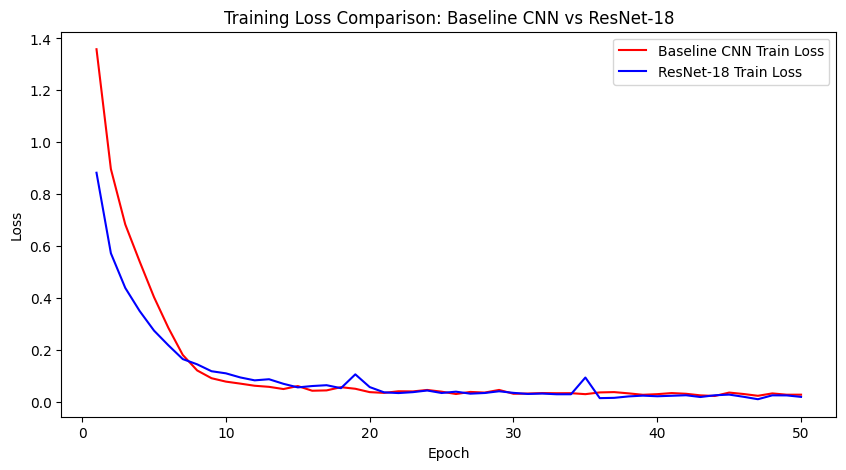

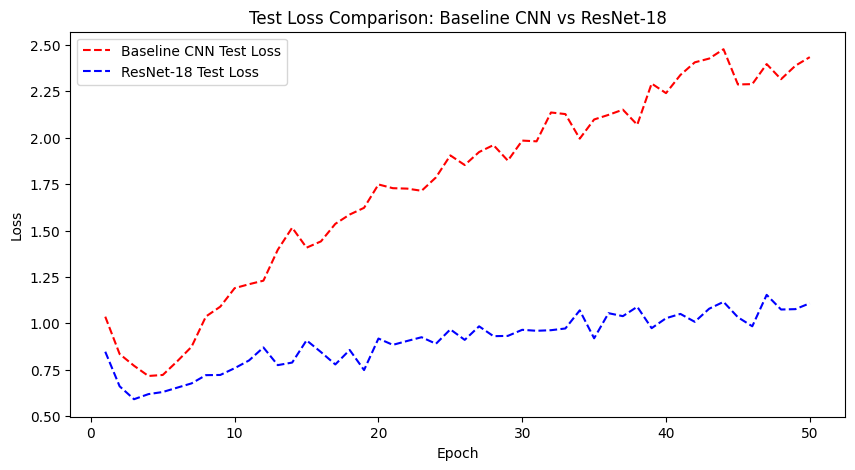

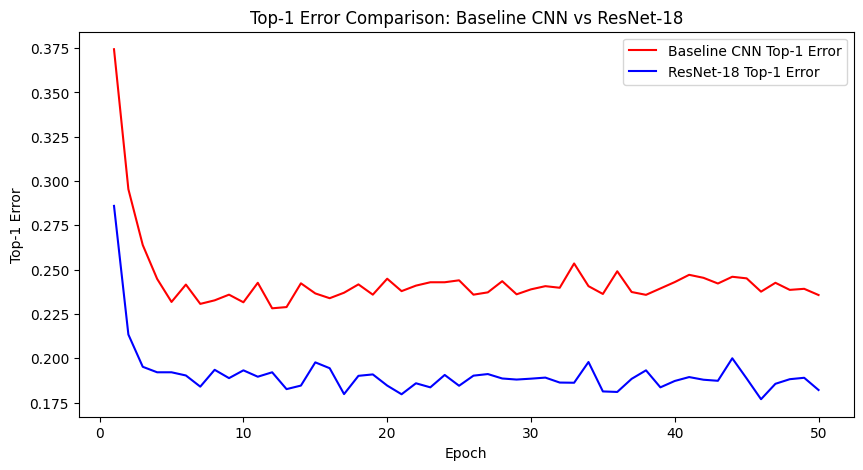

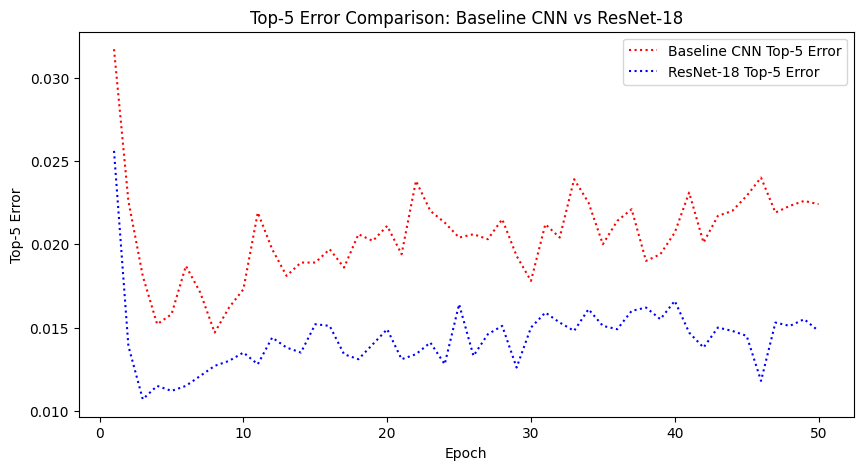

In [22]:
# Load results from CSV
df_baseline = pd.read_csv("baseline_results.csv")
df_resnet = pd.read_csv("resnet_results.csv")

# Plot Train Loss Comparison
plt.figure(figsize=(10, 5))
plt.plot(df_baseline["Epoch"], df_baseline["Train Loss"], label="Baseline CNN Train Loss", color="red")
plt.plot(df_resnet["Epoch"], df_resnet["Train Loss"], label="ResNet-18 Train Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison: Baseline CNN vs ResNet-18")
plt.legend()
plt.show()

# Plot Test Loss Comparison
plt.figure(figsize=(10, 5))
plt.plot(df_baseline["Epoch"], df_baseline["Test Loss"], label="Baseline CNN Test Loss", color="red", linestyle="dashed")
plt.plot(df_resnet["Epoch"], df_resnet["Test Loss"], label="ResNet-18 Test Loss", color="blue", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test Loss Comparison: Baseline CNN vs ResNet-18")
plt.legend()
plt.show()

# Plot Top-1 Error Comparison
plt.figure(figsize=(10, 5))
plt.plot(df_baseline["Epoch"], df_baseline["Top-1 Error"], label="Baseline CNN Top-1 Error", color="red")
plt.plot(df_resnet["Epoch"], df_resnet["Top-1 Error"], label="ResNet-18 Top-1 Error", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Top-1 Error")
plt.title("Top-1 Error Comparison: Baseline CNN vs ResNet-18")
plt.legend()
plt.show()

# Plot Top-5 Error Comparison
plt.figure(figsize=(10, 5))
plt.plot(df_baseline["Epoch"], df_baseline["Top-5 Error"], label="Baseline CNN Top-5 Error", color="red", linestyle="dotted")
plt.plot(df_resnet["Epoch"], df_resnet["Top-5 Error"], label="ResNet-18 Top-5 Error", color="blue", linestyle="dotted")
plt.xlabel("Epoch")
plt.ylabel("Top-5 Error")
plt.title("Top-5 Error Comparison: Baseline CNN vs ResNet-18")
plt.legend()
plt.show()



The first image shows how the training loss evolves for both the Baseline CNN and ResNet-18. At the start, both models see a sharp drop in loss, meaning they’re quickly learning patterns from the data. As training continues, the curves nearly merge, with both approaching zero loss. I’d say this means they’re optimizing well on the training set, but that doesn’t necessarily tell us which one generalizes better.
The second image is where things get more interesting—it’s the test loss comparison. At first, both models start off similarly, but then the Baseline CNN’s test loss starts creeping up while ResNet-18 remains much more stable. It’s clear that the Baseline CNN is struggling with overfitting, memorizing training patterns instead of learning general features. ResNet-18, on the other hand, keeps its loss relatively low, which makes sense given its deeper architecture and residual connections helping it preserve important information.
The third image focuses on Top-1 error, and again, the difference is pretty obvious. The Baseline CNN starts off with a much higher error rate and doesn’t improve as efficiently. ResNet-18, though, manages to keep its error significantly lower throughout the entire training process. The deeper layers in ResNet-18 are doing a better job at extracting meaningful features, which helps it make more accurate single-label predictions.
The fourth image shows the Top-5 error, and honestly, it’s more of the same story. The Baseline CNN has a rough start with high fluctuations, while ResNet-18 settles into a consistently lower error rate. Lower Top-5 error tells us that ResNet-18 is better at capturing detailed features, making sure the correct label is in its top five predictions more often. Meanwhile, the Baseline CNN just can’t keep up, struggling with complex representations.
Looking at these plots together, I think it’s pretty clear that ResNet-18 has the upper hand in almost every way. It generalizes better, keeps test loss in check, and consistently outperforms the Baseline CNN on both Top-1 and Top-5 errors. The residual connections and deeper layers seem to make all the difference here.

So I finally finished running EfficientNetB0(detail set up and running could be fined in file P2(2)), and below I pasted my result into corresponding place of the code snippet and make a comparison with these three models.

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Sample log data for three models (Baseline CNN, ResNet-18, EfficientNet-B0)
log_baseline = """
Epoch [1/50], Train Loss: 1.3584, Test Loss: 1.0360, Top-1 Error: 0.3744, Top-5 Error: 0.0317
Epoch [2/50], Train Loss: 0.8970, Test Loss: 0.8347, Top-1 Error: 0.2954, Top-5 Error: 0.0226
...
Epoch [50/50], Train Loss: 0.0277, Test Loss: 2.4345, Top-1 Error: 0.2357, Top-5 Error: 0.0224"""

log_resnet = """
Epoch [1/50], Train Loss: 0.8826, Test Loss: 0.8471, Top-1 Error: 0.2860, Top-5 Error: 0.0256
Epoch [2/50], Train Loss: 0.5725, Test Loss: 0.6608, Top-1 Error: 0.2134, Top-5 Error: 0.0139
...
Epoch [50/50], Train Loss: 0.0192, Test Loss: 1.1082, Top-1 Error: 0.1821, Top-5 Error: 0.0148"""

log_efficientnet = """
Epoch [1/50], Train Loss: 0.3327, Test Loss: 0.2019, Top-1 Error: 0.0651, Top-5 Error: 0.0015
Epoch [2/50], Train Loss: 0.1553, Test Loss: 0.1715, Top-1 Error: 0.0571, Top-5 Error: 0.0008
Epoch [3/50], Train Loss: 0.1138, Test Loss: 0.1876, Top-1 Error: 0.0584, Top-5 Error: 0.0012
Epoch [4/50], Train Loss: 0.0898, Test Loss: 0.1829, Top-1 Error: 0.0532, Top-5 Error: 0.0008
Epoch [5/50], Train Loss: 0.0774, Test Loss: 0.2069, Top-1 Error: 0.0617, Top-5 Error: 0.0014
✅ Checkpoint saved at epoch 5

Epoch [6/50], Train Loss: 0.0663, Test Loss: 0.1973, Top-1 Error: 0.0546, Top-5 Error: 0.0009
Epoch [7/50], Train Loss: 0.0602, Test Loss: 0.1886, Top-1 Error: 0.0509, Top-5 Error: 0.0009
Epoch [8/50], Train Loss: 0.0534, Test Loss: 0.1976, Top-1 Error: 0.0559, Top-5 Error: 0.0013
Epoch [9/50], Train Loss: 0.0498, Test Loss: 0.2179, Top-1 Error: 0.0604, Top-5 Error: 0.0016
Epoch [10/50], Train Loss: 0.0486, Test Loss: 0.1950, Top-1 Error: 0.0547, Top-5 Error: 0.0010
✅ Checkpoint saved at epoch 10

Epoch [11/50], Train Loss: 0.0418, Test Loss: 0.2082, Top-1 Error: 0.0542, Top-5 Error: 0.0014
Epoch [12/50], Train Loss: 0.0405, Test Loss: 0.1981, Top-1 Error: 0.0513, Top-5 Error: 0.0024
Epoch [13/50], Train Loss: 0.0384, Test Loss: 0.2225, Top-1 Error: 0.0535, Top-5 Error: 0.0024
Epoch [14/50], Train Loss: 0.0383, Test Loss: 0.1809, Top-1 Error: 0.0494, Top-5 Error: 0.0010
Epoch [15/50], Train Loss: 0.0315, Test Loss: 0.2492, Top-1 Error: 0.0630, Top-5 Error: 0.0011
✅ Checkpoint saved at epoch 15

Epoch [16/50], Train Loss: 0.0382, Test Loss: 0.1980, Top-1 Error: 0.0507, Top-5 Error: 0.0011
Epoch [17/50], Train Loss: 0.0312, Test Loss: 0.1926, Top-1 Error: 0.0488, Top-5 Error: 0.0009
Epoch [18/50], Train Loss: 0.0309, Test Loss: 0.2037, Top-1 Error: 0.0494, Top-5 Error: 0.0011
Epoch [19/50], Train Loss: 0.0306, Test Loss: 0.2216, Top-1 Error: 0.0548, Top-5 Error: 0.0009
Epoch [20/50], Train Loss: 0.0270, Test Loss: 0.2725, Top-1 Error: 0.0650, Top-5 Error: 0.0013
✅ Checkpoint saved at epoch 20

Epoch [21/50], Train Loss: 0.0299, Test Loss: 0.2205, Top-1 Error: 0.0547, Top-5 Error: 0.0011
Epoch [22/50], Train Loss: 0.0275, Test Loss: 0.2360, Top-1 Error: 0.0567, Top-5 Error: 0.0013
Epoch [23/50], Train Loss: 0.0254, Test Loss: 0.2414, Top-1 Error: 0.0520, Top-5 Error: 0.0018
Epoch [24/50], Train Loss: 0.0267, Test Loss: 0.2221, Top-1 Error: 0.0514, Top-5 Error: 0.0019
Epoch [25/50], Train Loss: 0.0215, Test Loss: 0.2313, Top-1 Error: 0.0530, Top-5 Error: 0.0020
✅ Checkpoint saved at epoch 25

Epoch [26/50], Train Loss: 0.0243, Test Loss: 0.2457, Top-1 Error: 0.0558, Top-5 Error: 0.0021
Epoch [27/50], Train Loss: 0.0251, Test Loss: 0.2424, Top-1 Error: 0.0561, Top-5 Error: 0.0014
Epoch [28/50], Train Loss: 0.0217, Test Loss: 0.2334, Top-1 Error: 0.0517, Top-5 Error: 0.0015
Epoch [29/50], Train Loss: 0.0195, Test Loss: 0.2487, Top-1 Error: 0.0534, Top-5 Error: 0.0016
Epoch [30/50], Train Loss: 0.0231, Test Loss: 0.2514, Top-1 Error: 0.0567, Top-5 Error: 0.0018
✅ Checkpoint saved at epoch 30

Epoch [31/50], Train Loss: 0.0215, Test Loss: 0.2523, Top-1 Error: 0.0515, Top-5 Error: 0.0025
Epoch [32/50], Train Loss: 0.0180, Test Loss: 0.2402, Top-1 Error: 0.0481, Top-5 Error: 0.0014
Epoch [33/50], Train Loss: 0.0209, Test Loss: 0.2361, Top-1 Error: 0.0512, Top-5 Error: 0.0016
Epoch [34/50], Train Loss: 0.0198, Test Loss: 0.2336, Top-1 Error: 0.0525, Top-5 Error: 0.0020
Epoch [35/50], Train Loss: 0.0194, Test Loss: 0.2378, Top-1 Error: 0.0481, Top-5 Error: 0.0014
✅ Checkpoint saved at epoch 35

Epoch [36/50], Train Loss: 0.0177, Test Loss: 0.2398, Top-1 Error: 0.0502, Top-5 Error: 0.0017
Epoch [37/50], Train Loss: 0.0149, Test Loss: 0.2656, Top-1 Error: 0.0552, Top-5 Error: 0.0016
Epoch [38/50], Train Loss: 0.0190, Test Loss: 0.2458, Top-1 Error: 0.0516, Top-5 Error: 0.0017
Epoch [39/50], Train Loss: 0.0132, Test Loss: 0.2428, Top-1 Error: 0.0515, Top-5 Error: 0.0009
Epoch [40/50], Train Loss: 0.0198, Test Loss: 0.2382, Top-1 Error: 0.0520, Top-5 Error: 0.0012
✅ Checkpoint saved at epoch 40

Epoch [41/50], Train Loss: 0.0162, Test Loss: 0.2386, Top-1 Error: 0.0524, Top-5 Error: 0.0025
Epoch [42/50], Train Loss: 0.0159, Test Loss: 0.2525, Top-1 Error: 0.0494, Top-5 Error: 0.0022
Epoch [43/50], Train Loss: 0.0156, Test Loss: 0.2659, Top-1 Error: 0.0541, Top-5 Error: 0.0013
Epoch [44/50], Train Loss: 0.0160, Test Loss: 0.2556, Top-1 Error: 0.0530, Top-5 Error: 0.0016
Epoch [45/50], Train Loss: 0.0158, Test Loss: 0.2675, Top-1 Error: 0.0551, Top-5 Error: 0.0023
✅ Checkpoint saved at epoch 45

Epoch [46/50], Train Loss: 0.0162, Test Loss: 0.2577, Top-1 Error: 0.0549, Top-5 Error: 0.0021
Epoch [47/50], Train Loss: 0.0153, Test Loss: 0.2598, Top-1 Error: 0.0551, Top-5 Error: 0.0020
Epoch [48/50], Train Loss: 0.0124, Test Loss: 0.2635, Top-1 Error: 0.0516, Top-5 Error: 0.0019
Epoch [49/50], Train Loss: 0.0142, Test Loss: 0.2361, Top-1 Error: 0.0506, Top-5 Error: 0.0013
Epoch [50/50], Train Loss: 0.0159, Test Loss: 0.2928, Top-1 Error: 0.0610, Top-5 Error: 0.0017
✅ Checkpoint saved at epoch 50"""

# Regular expression to extract values, ignoring ✅ checkpoint messages
pattern = r"Epoch \[(\d+)/50\], Train Loss: ([\d.]+), Test Loss: ([\d.]+), Top-1 Error: ([\d.]+), Top-5 Error: ([\d.]+)"

# Function to extract results
def extract_results(log_text):
    matches = re.findall(pattern, log_text)
    df = pd.DataFrame(matches, columns=["Epoch", "Train Loss", "Test Loss", "Top-1 Error", "Top-5 Error"]).astype(float)
    return df

# Extract results for each model
df_efficientnet = extract_results(log_efficientnet)

# Save all three models' results to CSV
df_efficientnet.to_csv("efficientnet_results.csv", index=False)

print("✅ Results saved:'efficientnet_results.csv'")



✅ Results saved:'efficientnet_results.csv'


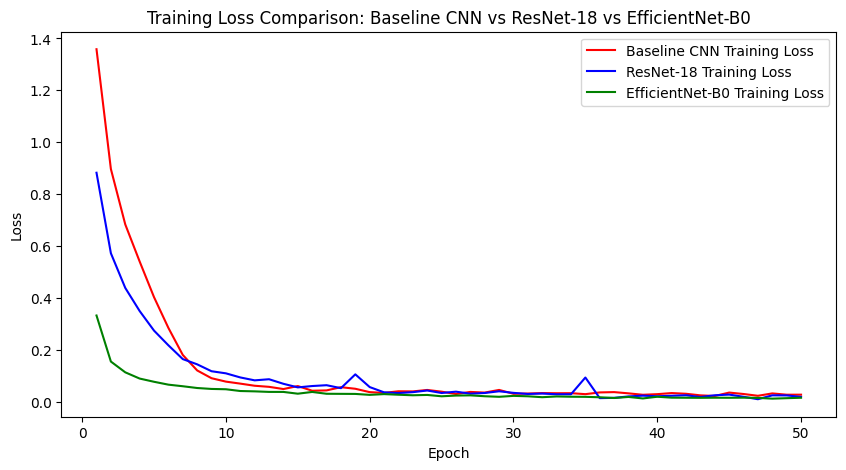

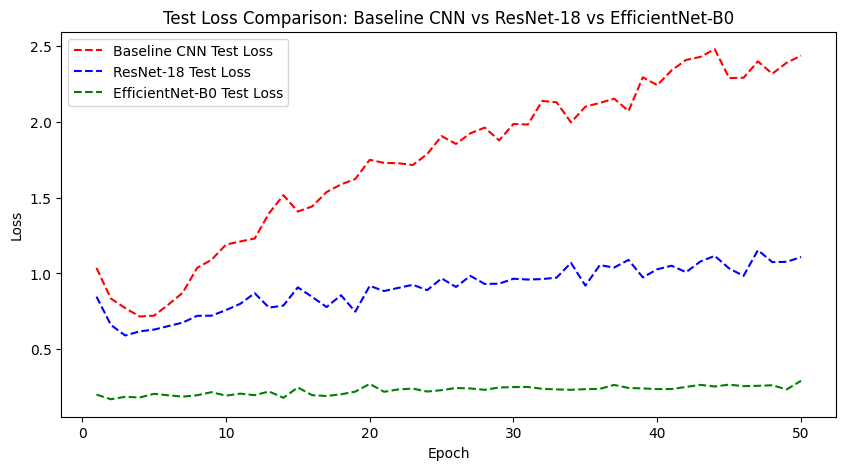

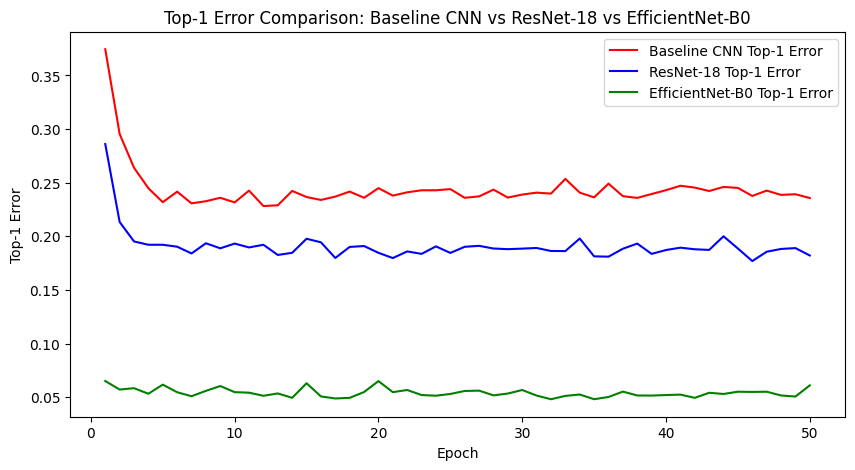

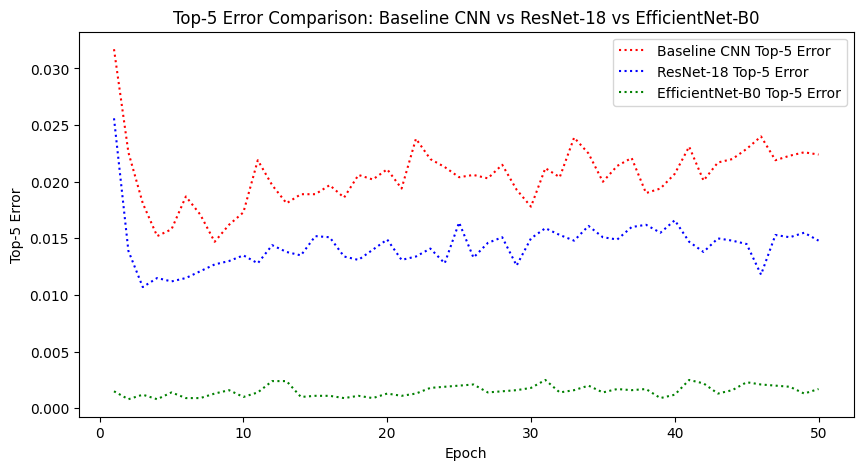

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results from CSV
df_baseline = pd.read_csv("baseline_results.csv")
df_resnet = pd.read_csv("resnet_results.csv")
df_efficientnet = pd.read_csv("efficientnet_results.csv")

# Function to plot comparisons
def plot_comparison(y_label, title, column_name, linestyle_baseline="solid", linestyle_resnet="solid", linestyle_effnet="solid"):
    plt.figure(figsize=(10, 5))
    plt.plot(df_baseline["Epoch"], df_baseline[column_name], label="Baseline CNN " + title, color="red", linestyle=linestyle_baseline)
    plt.plot(df_resnet["Epoch"], df_resnet[column_name], label="ResNet-18 " + title, color="blue", linestyle=linestyle_resnet)
    plt.plot(df_efficientnet["Epoch"], df_efficientnet[column_name], label="EfficientNet-B0 " + title, color="green", linestyle=linestyle_effnet)
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title + " Comparison: Baseline CNN vs ResNet-18 vs EfficientNet-B0")
    plt.show()

# Plot Training Loss Comparison
plot_comparison("Loss", "Training Loss", "Train Loss")

# Plot Test Loss Comparison
plot_comparison("Loss", "Test Loss", "Test Loss", linestyle_baseline="dashed", linestyle_resnet="dashed", linestyle_effnet="dashed")

# Plot Top-1 Error Comparison
plot_comparison("Top-1 Error", "Top-1 Error", "Top-1 Error")

# Plot Top-5 Error Comparison
plot_comparison("Top-5 Error", "Top-5 Error", "Top-5 Error", linestyle_baseline="dotted", linestyle_resnet="dotted", linestyle_effnet="dotted")


My five days of running this model worth it obviouly. Looking at these results, I noticed how EfficientNet-B0 just completely outclasses both ResNet-18 and the Baseline CNN. Its training loss drops fast and stabilizes effortlessly, while the other two models struggle to keep up. Test loss tells the same story—EfficientNet-B0 holds steady with the lowest values, while ResNet-18 does okay but fluctuates, and the Baseline CNN just keeps drifting, showing clear signs of overfitting. When I see the Top-1 error, it’s obvious that EfficientNet-B0 is operating on a whole different level, maintaining the lowest error consistently, whereas ResNet-18 follows behind and the Baseline CNN is just outmatched. But the real game-changer is the Top-5 error—EfficientNet-B0 nearly eliminates it from the start, proving just how precise it is. Meanwhile, ResNet-18 still manages to keep things under control, but the Baseline CNN keeps wobbling, reinforcing that it’s just not built to handle this level of classification. Honestly, seeing these results, I feel like the difference between older and newer architectures isn’t just theoretical—it’s right here, crystal clear, in the numbers.